# OPT125m Sentiment Analysis Experiments on Sentiment 140 Dataset using baseline model (and with PEFT -- LoRA, BitFit, Prompt Tuning)

In [4]:
"""We begin our process by installing packages such as pytorch, which is used extensively here, as well as HuggingFace's
transformers and datasets packages, which are used to run the OPT transformer model and load the Sentiment140 dataset, respectively. """

!pip install torch transformers datasets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
"""This step configures the credentials of the active user to seemlessly enable push and pull to and from the group's X-PERTS github repository"""

!git config --global credential.helper store

In [6]:
"""We next import the installed packages, namely the OPT model"""

import torch
from torch.utils.data import DataLoader
from datasets import load_dataset

from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding

import time
from sklearn.metrics import classification_report

In [8]:
""" We next instantiate (load) our temporary dataset, calling to our sentiment140.py script with a simple one-liner where this script handles the rest"""

dataset = load_dataset("/sentiment140.py", name="sentiment140")
full_train = dataset["train"]

print("Train size:", len(dataset["train"]))
print("Test size:", len(dataset["test"]))

The repository for sentiment140 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/sentiment140.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Train size: 1600000
Test size: 498


In [9]:
""" We next import a few packages for randomization of our sampling, re for text recognition and denoising and Datasets for creating our downsampled dataset"""

import random
import re
from datasets import Dataset

In [10]:
""" With the entire 1.6m entry dataset loaded in as full_train above, we next filter out entries labelled 2 (a 'neutral' sentiment class label,
though there seemed not to be any such instances), and we define negative and positive tweets, from which we randomly sample 25k instances each for class balance.
We lastly overwrite our dataset with just the 50k class-balanced records from pre-processing to ensure fast, tractable training is possible run locally given
our resource-efficiency computationally-constrained focus."""

all_data = [x for x in full_train if x["sentiment"] in [0,4]]

negative = [x for x in all_data if x["sentiment"] == 0]
positive = [x for x in all_data if x["sentiment"] == 4]

random.seed(42)

negative_sample = random.sample(negative, 25000)
positive_sample = random.sample(positive, 25000)

sampled_data = negative_sample + positive_sample

random.shuffle(sampled_data)

dataset = Dataset.from_list(sampled_data)

In [11]:
""" Next, with our 50k sentiment dataset, we perform pre-processing for standardization and to remove
noise in the form of mentions (e.g. @gatech), URLs (e.g. https://...), hashtags (e.g. #SwineFlu),
non-alphanumeric characters (e.g. emojis, capitalization, punctuation)"""

def clean_text(text):
  text = text.lower()
  text = re.sub(r"http\S+", "", text)
  text = re.sub(r"@\w+", "", text)
  text = re.sub(r"#\w+", "", text)
  text = re.sub(r"[^a-z0-9\s]", "", text)
  return text.strip()

dataset = dataset.map(lambda x: {"text": clean_text(x["text"])})

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [12]:
from huggingface_hub import login
token = ""

In [13]:
model_name = "facebook/opt-125m"
num_labels = 2
tokenizer = AutoTokenizer.from_pretrained(model_name, token=token)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, token=token)

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/251M [00:00<?, ?B/s]

Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
""" We apply mapping from the seemingly arbitrary 0,4 scale to 0,1 for standard binary classification"""

def map_labels(example):
    example["sentiment"] = 0 if example["sentiment"] == 0 else 1
    return example

dataset = dataset.map(map_labels)

print("Dataset size:", len(dataset))

from collections import Counter
print("Class distribution:", Counter(dataset["sentiment"]))

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/251M [00:00<?, ?B/s]

Dataset size: 50000
Class distribution: Counter({1: 25000, 0: 25000})


DOWNSAMPLING FOR TRAINING

In [15]:
""" We next perform downsampling and stratified splitting of the data 80/10/10 Train/Test/Val """

from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from collections import Counter
import pandas as pd

df = dataset.to_pandas()
df = df.dropna(subset=["text", "sentiment"])

print("Initial class distribution:", Counter(df["sentiment"]))

df_train, df_test = train_test_split(
    df,
    stratify=df["sentiment"],
    test_size=0.2,
    random_state=42
)

print("Train size:", len(df_train))
print("Test size:", len(df_test))
print("Train class distribution:", Counter(df_train["sentiment"]))
print("Test class distribution:", Counter(df_test["sentiment"]))

train_dataset = Dataset.from_pandas(df_train).remove_columns(["__index_level_0__"])
test_dataset  = Dataset.from_pandas(df_test).remove_columns(["__index_level_0__"])

def tokenize(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset  = test_dataset.map(tokenize, batched=True)

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "sentiment"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "sentiment"])

tokenized_dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

Initial class distribution: Counter({1: 25000, 0: 25000})
Train size: 40000
Test size: 10000
Train class distribution: Counter({1: 20000, 0: 20000})
Test class distribution: Counter({0: 5000, 1: 5000})


Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [16]:
""" We print the head of each of the train/test/val sets to visualize our cleaned data"""

print("\nSample training examples:")
display(df_train.head(5))

print("\nSample test examples:")
display(df_test.head(5))


Sample training examples:


,text,date,user,sentiment,query
47782,finally set up wireless internet huzzah for tw...,Sat May 30 23:43:31 PDT 2009,alexwilliamson,1,NO_QUERY
20407,lebron james please dont leave usfor the love ...,Sat May 30 20:58:04 PDT 2009,ryangetty,0,NO_QUERY
42997,i broke our site,Sat May 30 23:21:22 PDT 2009,DjDATZ,0,NO_QUERY
19678,ugh idk if thats going to be possible my frie...,Fri May 22 08:28:11 PDT 2009,JulieAnnCook,0,NO_QUERY
13754,wrong place at the wrong time always sigh,Wed Jun 17 08:20:28 PDT 2009,Nadiahazman,0,NO_QUERY



Sample test examples:


,text,date,user,sentiment,query
19138,morning all still very tired,Mon Jun 15 23:42:24 PDT 2009,SJB1990,0,NO_QUERY
39757,so i joined voicescom but i cant do much becau...,Sun May 10 08:38:25 PDT 2009,TsukinoUsako,0,NO_QUERY
30278,how many times have you wanted to say this to ...,Mon Apr 20 06:49:34 PDT 2009,rjacklin,1,NO_QUERY
42270,oh my luck my name is the cutoff line meaning...,Sat Jun 06 07:05:58 PDT 2009,PreAtlas,0,NO_QUERY
33544,my ipod frozen anyone kno how to fix it,Sat May 30 21:40:21 PDT 2009,yami_yami,0,NO_QUERY


In [17]:
""" We initialize our dataloader for each of the sets, fix their batch sizes
and randomize their order"""

train_loader = DataLoader(tokenized_dataset["train"], batch_size=16, shuffle=True)
test_loader  = DataLoader(tokenized_dataset["test"], batch_size=16)

In [18]:
""" We define our optimizer using Adam and set a conservative learning rate and
weight decay (though later hyperparameter search will overwrite)"""

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=5e-5,
    weight_decay=0.01
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

OPTForSequenceClassification(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 768, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 768)
      (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-11): 12 x OPTDecoderLayer(
          (self_attn): OPTSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): La


Baseline Inference Performance - OPT125m on Sentiment140


Test Accuracy   : 0.5237
F1 Score (macro): 0.5011
F1 Score (weighted): 0.5011
Inference Time  : 8.87s

Classification Report:
              precision    recall  f1-score   support

    Negative       0.52      0.74      0.61      5000
    Positive       0.54      0.31      0.40      5000

    accuracy                           0.52     10000
   macro avg       0.53      0.52      0.50     10000
weighted avg       0.53      0.52      0.50     10000



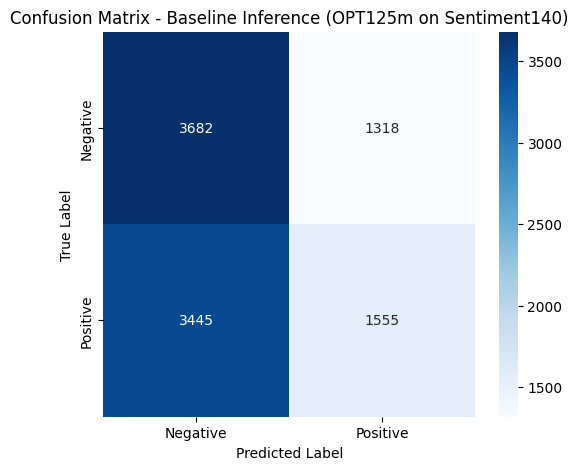

In [19]:
""" Baseline inference for binary sentiment analysis task run on OPT-125m
without PEFT (i.e. without BitFit and/or LoRA)"""

import time
import torch
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from torch import autocast

inference_start = time.time()

model.eval()
total_correct = 0
total_samples = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["sentiment"].to(device)

        with autocast(device_type='cuda'):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)

        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total_correct += (predictions == labels).sum().item()
        total_samples += labels.size(0)

accuracy = total_correct / total_samples
f1_macro = f1_score(all_labels, all_preds, average="macro")
f1_weighted = f1_score(all_labels, all_preds, average="weighted")
inference_time = time.time() - inference_start

print(f'\nBaseline Inference Performance - OPT125m on Sentiment140\n')
print(f"\nTest Accuracy   : {accuracy:.4f}")
print(f"F1 Score (macro): {f1_macro:.4f}")
print(f"F1 Score (weighted): {f1_weighted:.4f}")
print(f"Inference Time  : {inference_time:.2f}s")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["Negative", "Positive"]))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Baseline Inference (OPT125m on Sentiment140)")
plt.show()

# LORA

In [20]:
""" Install Parameter Efficient Finetuning Packages (e.g. LoRA and BitFit)"""

!pip install peft -q

In [21]:
""" Importing LoRA packages """

import gc
import torch
import time
import pandas as pd
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.metrics import classification_report, f1_score
from torch.utils.data import DataLoader

In [22]:
""" LoRA parameter setup """

learning_rates = [5e-5, 1e-4]
batch_sizes = [8, 16]
epochs = 6

In [23]:
""" Training on OPT-125m model using LoRA and output dataset generation (saved as .csv)"""

results = []

for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"Running LoRA with LR={lr}, batch_size={batch_size}")

        # loading OPT model
        model_name = "facebook/opt-125m"
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

        # LoRA param update config
        lora_config = LoraConfig(
            task_type=TaskType.SEQ_CLS,
            r=16,
            lora_alpha=32,
            lora_dropout=0.1,
            bias="none",
            target_modules=["q_proj", "v_proj"]
        )

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)

        # instantiate dataloader
        data_collator = DataCollatorWithPadding(tokenizer)
        train_dataloader = DataLoader(tokenized_dataset['train'], batch_size=batch_size, shuffle=True, collate_fn=data_collator)
        test_dataloader = DataLoader(tokenized_dataset['test'], batch_size=batch_size, shuffle=False, collate_fn=data_collator)

        # adam optimizer
        optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

        # begin training
        model.train()
        start_time = time.time()
        epoch_logs = []

        for epoch in range(1, epochs + 1):
            running_loss = 0.0
            correct = 0
            total = 0
            loop = tqdm(train_dataloader, leave=True, desc=f"Epoch {epoch}/{epochs}")
            for step, batch in enumerate(loop):

                batch = {
                    "input_ids": batch["input_ids"].to(device),
                    "attention_mask": batch["attention_mask"].to(device),
                    "labels": batch["sentiment"].to(device)
                }

                with autocast(device_type='cuda'):
                    outputs = model(**batch)
                    loss = outputs.loss
                    preds = torch.argmax(outputs.logits, dim=1)
                    correct += (preds == batch['labels']).sum().item()
                    total += batch['labels'].size(0)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()


            avg_train_loss = running_loss / (step + 1)
            train_accuracy = correct / total

            # perform per epoch evaluation
            model.eval()
            val_running_loss = 0.0
            y_true, y_pred = [], []
            inference_start = time.time()
            with torch.no_grad():
              with autocast(device_type='cuda'):
                    for batch in test_dataloader:
                        batch = {
                            "input_ids": batch["input_ids"].to(device),
                            "attention_mask": batch["attention_mask"].to(device),
                            "labels": batch["sentiment"].to(device)
                        }
                        outputs = model(**batch)
                        preds = torch.argmax(outputs.logits, dim=1)
                        y_true.extend(batch["labels"].cpu().numpy())
                        y_pred.extend(preds.cpu().numpy())
                        val_running_loss += outputs.loss.item()

            avg_val_loss = val_running_loss / len(test_dataloader)
            inference_time = time.time() - inference_start

            report = classification_report(y_true, y_pred, output_dict=True)
            val_accuracy = report["accuracy"]
            val_f1 = report["weighted avg"]["f1-score"]

            epoch_logs.append({
                "epoch": epoch,
                "lr": lr,
                "batch_size": batch_size,
                "train_loss": avg_train_loss,
                "train_accuracy": train_accuracy,
                "val_loss": avg_val_loss,
                "val_accuracy": val_accuracy
            })

            if epoch == epochs:
                total_correct = sum(yt == yp for yt, yp in zip(y_true, y_pred))
                total_samples = len(y_true)
                accuracy = total_correct / total_samples
                f1_macro = f1_score(y_true, y_pred, average="macro")
                f1_weighted = f1_score(y_true, y_pred, average="weighted")

                print(f"\n[Final Epoch {epoch}] Inference Metrics:")
                print(f"Test Accuracy      : {accuracy:.4f}")
                print(f"F1 Score (macro)   : {f1_macro:.4f}")
                print(f"F1 Score (weighted): {f1_weighted:.4f}")
                print(f"Inference Time     : {inference_time:.2f} seconds")
                print("\nClassification Report: OPT125m w/ LoRA on Sentiment140\n")
                print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))

            model.train()

        end_time = time.time()
        training_time = end_time - start_time

        # begin datalogging per lr/bs
        epoch_logs_df = pd.DataFrame(epoch_logs)
        epoch_logs_df.to_csv(f"sent_opt_lora_epoch_logs_lr{lr}_bs{batch_size}.csv", index=False)

        # saver inference metrics per lr/bs
        metrics_summary_df = pd.DataFrame(report).transpose()
        metrics_summary_df.to_csv(f"sent_opt_lora_inference_metrics_summary_lr{lr}_bs{batch_size}.csv", index=True)

        # save inference predictions for the final epoch
        predictions_df = pd.DataFrame({
            "y_true": y_true,
            "y_pred": y_pred
        })
        predictions_df.to_csv(f"sent_opt_lora_inference_predictions_lr{lr}_bs{batch_size}.csv", index=False)

        # log memory usage
        max_memory = torch.cuda.max_memory_allocated() / (1024 ** 3) if torch.cuda.is_available() else 0

        # save model params and metrics
        results.append({
            "method": "LoRA",
            "learning_rate": lr,
            "batch_size": batch_size,
            "accuracy": val_accuracy,
            "f1": val_f1,
            "training_time": training_time,
            "inference_time": inference_time,
            "max_memory": max_memory
        })

        # empty cache to conserve compute
        del model, tokenizer, optimizer
        torch.cuda.empty_cache()
        gc.collect()

# ranked performance by val acc
results = sorted(results, key=lambda x: x["accuracy"], reverse=True)

# save overall results
results_df = pd.DataFrame(results)
results_df.to_csv("sent_opt_lora_results.csv", index=False)

# save best final config and metrics
final_summary_df = pd.DataFrame({
    "Method": ["LoRA"],
    "Best LR": [results[0]["learning_rate"]],
    "Best Batch Size": [results[0]["batch_size"]],
    "Accuracy": [results[0]["accuracy"]],
    "F1 Score": [results[0]["f1"]],
    "Training Time (s)": [results[0]["training_time"]],
    "Inference Time (s)": [results[0]["inference_time"]],
    "Max GPU Memory (GB)": [results[0]["max_memory"]]
})
final_summary_df.to_csv("sent_opt_lora_final_comparison_lora.csv", index=False)

print("All LoRA Grid Search Results:")
for r in results:
    print(r)

print("\nBest LoRA Configuration:")
print(results[0])

Running LoRA with LR=5e-05, batch_size=8


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 6/6: 100%|██████████| 5000/5000 [04:02<00:00, 20.58it/s]



[Final Epoch 6] Inference Metrics:
Test Accuracy      : 0.7837
F1 Score (macro)   : 0.7835
F1 Score (weighted): 0.7835
Inference Time     : 14.54 seconds

Classification Report: OPT125m w/ LoRA on Sentiment140

              precision    recall  f1-score   support

    Negative       0.80      0.76      0.78      5000
    Positive       0.77      0.81      0.79      5000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000

Running LoRA with LR=5e-05, batch_size=16


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 6/6: 100%|██████████| 2500/2500 [02:10<00:00, 19.20it/s]



[Final Epoch 6] Inference Metrics:
Test Accuracy      : 0.7883
F1 Score (macro)   : 0.7877
F1 Score (weighted): 0.7877
Inference Time     : 7.89 seconds

Classification Report: OPT125m w/ LoRA on Sentiment140

              precision    recall  f1-score   support

    Negative       0.82      0.73      0.78      5000
    Positive       0.76      0.84      0.80      5000

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000

Running LoRA with LR=0.0001, batch_size=8


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 6/6: 100%|██████████| 5000/5000 [04:05<00:00, 20.38it/s]



[Final Epoch 6] Inference Metrics:
Test Accuracy      : 0.7393
F1 Score (macro)   : 0.7393
F1 Score (weighted): 0.7393
Inference Time     : 14.58 seconds

Classification Report: OPT125m w/ LoRA on Sentiment140

              precision    recall  f1-score   support

    Negative       0.74      0.73      0.74      5000
    Positive       0.73      0.75      0.74      5000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000

Running LoRA with LR=0.0001, batch_size=16


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 6/6: 100%|██████████| 2500/2500 [02:10<00:00, 19.19it/s]



[Final Epoch 6] Inference Metrics:
Test Accuracy      : 0.7510
F1 Score (macro)   : 0.7508
F1 Score (weighted): 0.7508
Inference Time     : 7.89 seconds

Classification Report: OPT125m w/ LoRA on Sentiment140

              precision    recall  f1-score   support

    Negative       0.77      0.72      0.74      5000
    Positive       0.74      0.78      0.76      5000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

All LoRA Grid Search Results:
{'method': 'LoRA', 'learning_rate': 5e-05, 'batch_size': 16, 'accuracy': 0.7883, 'f1': 0.7876693248120229, 'training_time': 816.8391535282135, 'inference_time': 7.885466575622559, 'max_memory': 4.302315711975098}
{'method': 'LoRA', 'learning_rate': 5e-05, 'batch_size': 8, 'accuracy': 0.7837, 'f1': 0.783531498753945, 'training_time': 1555.0762033462524, 'inference_time': 14.53798222541809, 'max_memory': 3.1386966705322266}
{'meth


Classification Report for Best Configuration:
     Unnamed: 0  precision  recall  f1-score     support
0             0   0.823569  0.7338  0.776097   5000.0000
1             1   0.759964  0.8428  0.799241   5000.0000
2      accuracy   0.788300  0.7883  0.788300      0.7883
3     macro avg   0.791766  0.7883  0.787669  10000.0000
4  weighted avg   0.791766  0.7883  0.787669  10000.0000

Inference Predictions for Best Configuration:
      y_true  y_pred
0          0       0
1          0       0
2          1       0
3          0       1
4          0       0
...      ...     ...
9995       0       1
9996       0       1
9997       0       0
9998       1       1
9999       0       0

[10000 rows x 2 columns]


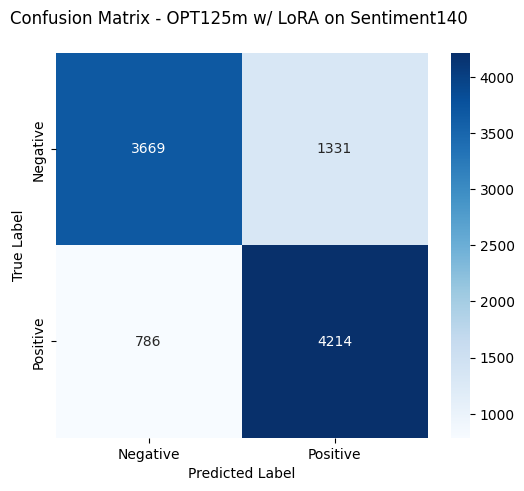

In [24]:
lora_best_lr = results[0]["learning_rate"]
lora_best_bs = results[0]["batch_size"]

# Construct filename
best_report_file = f"sent_opt_lora_inference_metrics_summary_lr{lora_best_lr}_bs{lora_best_bs}.csv"

# Load the saved best report
best_report_df = pd.read_csv(best_report_file)
print("\nClassification Report for Best Configuration:")
print(best_report_df)


best_preds_df = pd.read_csv(f"sent_opt_lora_inference_predictions_lr{lora_best_lr}_bs{lora_best_bs}.csv")
print("\nInference Predictions for Best Configuration:")
print(best_preds_df)

y_true = best_preds_df["y_true"]
y_pred = best_preds_df["y_pred"]


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - OPT125m w/ LoRA on Sentiment140 \n")
plt.show()

# BITFIT

In [25]:
""" Importing BitFit packages """

import gc
import torch
import time
import pandas as pd
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.metrics import classification_report, f1_score
from torch.utils.data import DataLoader

In [26]:
""" BitFit parameter setup """
learning_rates = [5e-5, 1e-4]
batch_sizes = [8, 16]
epochs = 6

In [27]:
""" Training on OPT-125m model using BitFit and output dataset generation (saved as .csv)"""

results = []

for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"Running BitFit with LR={lr}, batch_size={batch_size}")

        # loading OPT model
        model_name = "facebook/opt-125m"
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

        # BitFit param update config
        for name, param in model.named_parameters():
            if "bias" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)

        # instantiate dataloader
        data_collator = DataCollatorWithPadding(tokenizer)
        train_dataloader = DataLoader(tokenized_dataset["train"], batch_size=batch_size, shuffle=True, collate_fn=data_collator)
        test_dataloader = DataLoader(tokenized_dataset["test"], batch_size=batch_size, shuffle=False, collate_fn=data_collator)

        # adam optimizer
        optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

        # begin training
        model.train()
        start_time = time.time()
        epoch_logs = []

        for epoch in range(1, epochs + 1):
            running_loss = 0.0
            correct = 0
            total = 0
            loop = tqdm(train_dataloader, leave=True, desc=f"Epoch {epoch}/{epochs}")
            for step, batch in enumerate(loop):

                batch = {
                    "input_ids": batch["input_ids"].to(device),
                    "attention_mask": batch["attention_mask"].to(device),
                    "labels": batch["sentiment"].to(device)
                }

                with autocast(device_type='cuda'):
                    outputs = model(**batch)
                    loss = outputs.loss
                    preds = torch.argmax(outputs.logits, dim=1)
                    correct += (preds == batch['labels']).sum().item()
                    total += batch['labels'].size(0)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()

            avg_train_loss = running_loss / (step + 1)
            train_accuracy = correct / total

            # perform per epoch evaluation
            model.eval()
            val_running_loss = 0.0
            y_true, y_pred = [], []
            inference_start = time.time()
            with torch.no_grad():
                with autocast(device_type='cuda'):
                    for batch in test_dataloader:
                        batch = {
                            "input_ids": batch["input_ids"].to(device),
                            "attention_mask": batch["attention_mask"].to(device),
                            "labels": batch["sentiment"].to(device)
                        }
                        outputs = model(**batch)
                        preds = torch.argmax(outputs.logits, dim=1)
                        y_true.extend(batch["labels"].cpu().numpy())
                        y_pred.extend(preds.cpu().numpy())
                        val_running_loss += outputs.loss.item()

            avg_val_loss = val_running_loss / len(test_dataloader)

            inference_time = time.time() - inference_start

            report = classification_report(y_true, y_pred, output_dict=True)
            val_accuracy = report["accuracy"]
            val_f1 = report["weighted avg"]["f1-score"]

            epoch_logs.append({
                "epoch": epoch,
                "lr": lr,
                "batch_size": batch_size,
                "train_loss": avg_train_loss,
                "train_accuracy": train_accuracy,
                "val_loss": avg_val_loss,
                "val_accuracy": val_accuracy
            })

            if epoch == epochs:
                total_correct = sum(yt == yp for yt, yp in zip(y_true, y_pred))
                total_samples = len(y_true)
                accuracy = total_correct / total_samples
                f1_macro = f1_score(y_true, y_pred, average="macro")
                f1_weighted = f1_score(y_true, y_pred, average="weighted")

                print(f"\n[Final Epoch {epoch}] Inference Metrics:")
                print(f"Test Accuracy      : {accuracy:.4f}")
                print(f"F1 Score (macro)   : {f1_macro:.4f}")
                print(f"F1 Score (weighted): {f1_weighted:.4f}")
                print(f"Inference Time     : {inference_time:.2f} seconds")
                print("\nClassification Report: OPT125m w/ BitFit on Sentiment140\n")
                print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))

            model.train()

        end_time = time.time()
        training_time = end_time - start_time

        # begin datalogging per lr/bs
        epoch_logs_df = pd.DataFrame(epoch_logs)
        epoch_logs_df.to_csv(f"sent_opt_bitfit_epoch_logs_lr{lr}_bs{batch_size}.csv", index=False)

        # saver inference metrics per lr/bs
        metrics_summary_df = pd.DataFrame(report).transpose()
        metrics_summary_df.to_csv(f"sent_opt_bitfit_inference_metrics_summary_lr{lr}_bs{batch_size}.csv", index=True)

        # save inference predictions for the final epoch
        predictions_df = pd.DataFrame({
            "y_true": y_true,
            "y_pred": y_pred
        })
        predictions_df.to_csv(f"sent_opt_bitfit_inference_predictions_lr{lr}_bs{batch_size}.csv", index=False)

        # log memory usage
        max_memory = torch.cuda.max_memory_allocated() / (1024 ** 3) if torch.cuda.is_available() else 0

        # save model params and metrics
        results.append({
            "method": "BitFit",
            "learning_rate": lr,
            "batch_size": batch_size,
            "accuracy": val_accuracy,
            "f1": val_f1,
            "training_time": training_time,
            "inference_time": inference_time,
            "max_memory": max_memory
        })

        # empty cache to conserve compute
        del model, tokenizer, optimizer
        torch.cuda.empty_cache()
        gc.collect()

# ranked performance by val acc
results = sorted(results, key=lambda x: x["accuracy"], reverse=True)

# save overall results
results_df = pd.DataFrame(results)
results_df.to_csv("sent_opt_bitfit_results.csv", index=False)

# save best final config and metrics
final_summary_df = pd.DataFrame({
    "Method": ["BitFit"],
    "Best LR": [results[0]["learning_rate"]],
    "Best Batch Size": [results[0]["batch_size"]],
    "Accuracy": [results[0]["accuracy"]],
    "F1 Score": [results[0]["f1"]],
    "Training Time (s)": [results[0]["training_time"]],
    "Inference Time (s)": [results[0]["inference_time"]],
    "Max GPU Memory (GB)": [results[0]["max_memory"]]
})
final_summary_df.to_csv("sent_opt_bf_final_comparison_bitfit.csv", index=False)

print("All BitFit Grid Search Results:")
for r in results:
    print(r)

print("\nBest BitFit Configuration:")
print(results[0])


Running BitFit with LR=5e-05, batch_size=8


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 6/6: 100%|██████████| 5000/5000 [02:58<00:00, 28.00it/s]



[Final Epoch 6] Inference Metrics:
Test Accuracy      : 0.8137
F1 Score (macro)   : 0.8127
F1 Score (weighted): 0.8127
Inference Time     : 15.51 seconds

Classification Report: OPT125m w/ BitFit on Sentiment140

              precision    recall  f1-score   support

    Negative       0.77      0.89      0.83      5000
    Positive       0.87      0.74      0.80      5000

    accuracy                           0.81     10000
   macro avg       0.82      0.81      0.81     10000
weighted avg       0.82      0.81      0.81     10000

Running BitFit with LR=5e-05, batch_size=16


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 6/6: 100%|██████████| 2500/2500 [01:34<00:00, 26.56it/s]



[Final Epoch 6] Inference Metrics:
Test Accuracy      : 0.8282
F1 Score (macro)   : 0.8282
F1 Score (weighted): 0.8282
Inference Time     : 8.57 seconds

Classification Report: OPT125m w/ BitFit on Sentiment140

              precision    recall  f1-score   support

    Negative       0.84      0.82      0.83      5000
    Positive       0.82      0.84      0.83      5000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000

Running BitFit with LR=0.0001, batch_size=8


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 6/6: 100%|██████████| 5000/5000 [02:58<00:00, 28.04it/s]



[Final Epoch 6] Inference Metrics:
Test Accuracy      : 0.8280
F1 Score (macro)   : 0.8277
F1 Score (weighted): 0.8277
Inference Time     : 15.82 seconds

Classification Report: OPT125m w/ BitFit on Sentiment140

              precision    recall  f1-score   support

    Negative       0.80      0.87      0.84      5000
    Positive       0.86      0.78      0.82      5000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000

Running BitFit with LR=0.0001, batch_size=16


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 6/6: 100%|██████████| 2500/2500 [01:32<00:00, 26.90it/s]



[Final Epoch 6] Inference Metrics:
Test Accuracy      : 0.8203
F1 Score (macro)   : 0.8198
F1 Score (weighted): 0.8198
Inference Time     : 8.42 seconds

Classification Report: OPT125m w/ BitFit on Sentiment140

              precision    recall  f1-score   support

    Negative       0.79      0.87      0.83      5000
    Positive       0.86      0.77      0.81      5000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000

All BitFit Grid Search Results:
{'method': 'BitFit', 'learning_rate': 5e-05, 'batch_size': 16, 'accuracy': 0.8282, 'f1': 0.8281792096843718, 'training_time': 611.6768732070923, 'inference_time': 8.573552370071411, 'max_memory': 4.302315711975098}
{'method': 'BitFit', 'learning_rate': 0.0001, 'batch_size': 8, 'accuracy': 0.828, 'f1': 0.8276633161609847, 'training_time': 1172.1165475845337, 'inference_time': 15.820268869400024, 'max_memory': 4.30231571197509


Classification Report for Best Configuration:
     Unnamed: 0  precision  recall  f1-score     support
0             0   0.835583  0.8172  0.826289   5000.0000
1             1   0.821135  0.8392  0.830069   5000.0000
2      accuracy   0.828200  0.8282  0.828200      0.8282
3     macro avg   0.828359  0.8282  0.828179  10000.0000
4  weighted avg   0.828359  0.8282  0.828179  10000.0000

Inference Predictions for Best Configuration:
      y_true  y_pred
0          0       0
1          0       0
2          1       1
3          0       0
4          0       0
...      ...     ...
9995       0       0
9996       0       0
9997       0       0
9998       1       1
9999       0       0

[10000 rows x 2 columns]


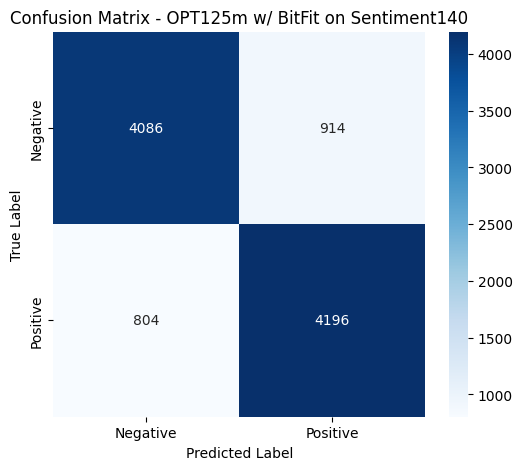

In [28]:
bf_best_lr = results[0]["learning_rate"]
bf_best_bs = results[0]["batch_size"]

# Construct filename
best_report_file = f"sent_opt_bitfit_inference_metrics_summary_lr{bf_best_lr}_bs{bf_best_bs}.csv"

# Load the saved best report
best_report_df = pd.read_csv(best_report_file)
print("\nClassification Report for Best Configuration:")
print(best_report_df)


best_preds_df = pd.read_csv(f"sent_opt_bitfit_inference_predictions_lr{bf_best_lr}_bs{bf_best_bs}.csv")
print("\nInference Predictions for Best Configuration:")
print(best_preds_df)

y_true = best_preds_df["y_true"]
y_pred = best_preds_df["y_pred"]


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - OPT125m w/ BitFit on Sentiment140")
plt.show()

## Prompt Tuning

In [29]:
""" Importing prompt tuning packages from PEFT """

import gc
from peft import PromptTuningConfig, PromptTuningInit, get_peft_model, TaskType

In [30]:
""" Prompt tuning parameter setup """

lrs = [5e-5, 1e-4]
bs = [8, 16]
num_tokens = 20
epochs = 6

In [33]:
""" Training and evaluation loop with hyperparamter grid search """

results = []

for lr in lrs:
    for batch_size in bs:
        print(f"Running Prompt Tuning with LR={lr}, batch_size={batch_size}")

        # loading OPT model
        model_name = "facebook/opt-125m"
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

        # prompt tuning config
        peft_config = PromptTuningConfig(
            task_type=TaskType.SEQ_CLS,
            num_virtual_tokens=num_tokens,
            tokenizer_name_or_path=tokenizer.name_or_path,
            prompt_tuning_init=PromptTuningInit.RANDOM,
        )
        prompt_model = get_peft_model(model, peft_config)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        prompt_model.to(device)

        # instantiate dataloader
        data_collator = DataCollatorWithPadding(tokenizer)
        train_dataloader = DataLoader(tokenized_dataset["train"], batch_size=batch_size, shuffle=True, collate_fn=data_collator)
        test_dataloader = DataLoader(tokenized_dataset["test"], batch_size=batch_size, shuffle=False, collate_fn=data_collator)

        # adam optimization
        optimizer = torch.optim.AdamW(prompt_model.parameters(), lr=lr)

        # begin training
        prompt_model.train()
        start_time = time.time()
        epoch_logs = []

        for epoch in range(1, epochs + 1):
            running_loss = 0.0
            correct = 0
            total = 0
            loop = tqdm(train_dataloader, leave=True, desc=f"Epoch {epoch}/{epochs}")
            for step, batch in enumerate(loop):

                batch = {
                    "input_ids": batch["input_ids"].to(device),
                    "attention_mask": batch["attention_mask"].to(device),
                    "labels": batch["sentiment"].to(device)
                }

                with autocast(device_type='cuda'):
                    outputs = model(**batch)
                    loss = outputs.loss
                    preds = torch.argmax(outputs.logits, dim=1)
                    correct += (preds == batch['labels']).sum().item()
                    total += batch['labels'].size(0)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()

            avg_train_loss = running_loss / (step + 1)
            train_accuracy = correct / total

            # perform per epoch evaluation
            prompt_model.eval()
            val_running_loss = 0.0
            y_true, y_pred = [], []
            with torch.no_grad():
                with autocast(device_type='cuda'):
                    for batch in test_dataloader:
                        batch = {
                            "input_ids": batch["input_ids"].to(device),
                            "attention_mask": batch["attention_mask"].to(device),
                            "labels": batch["sentiment"].to(device)
                        }
                        outputs = model(**batch)
                        preds = torch.argmax(outputs.logits, dim=1)
                        y_true.extend(batch["labels"].cpu().numpy())
                        y_pred.extend(preds.cpu().numpy())
                        val_running_loss += outputs.loss.item()

            avg_val_loss = val_running_loss / len(test_dataloader)

            inference_time = time.time() - start_time

            report = classification_report(y_true, y_pred, output_dict=True)
            val_accuracy = report["accuracy"]
            val_f1 = report["weighted avg"]["f1-score"]

            # print classification report on final epoch
            if epoch == epochs:
                total_correct = sum(yt == yp for yt, yp in zip(y_true, y_pred))
                total_samples = len(y_true)

                accuracy = total_correct / total_samples
                f1_macro = f1_score(y_true, y_pred, average="macro")
                f1_weighted = f1_score(y_true, y_pred, average="weighted")

                print(f"\n[Final Epoch {epoch}] Inference Metrics:")
                print(f"Test Accuracy      : {accuracy:.4f}")
                print(f"F1 Score (macro)   : {f1_macro:.4f}")
                print(f"F1 Score (weighted): {f1_weighted:.4f}")
                print(f"Inference Time     : {inference_time:.2f} seconds")
                print("\nClassification Report: - OPT125m w/ Prompt Tuning on Sentiment140\n")
                print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))

            epoch_logs.append({
                "epoch": epoch,
                "lr": lr,
                "batch_size": batch_size,
                "train_loss": avg_train_loss,
                "train_accuracy": train_accuracy,
                "val_loss": avg_val_loss,
                "val_accuracy": val_accuracy
            })

            prompt_model.train()

        end_time = time.time()
        training_time = end_time - start_time

        # begin datalogging per lr/bs
        epoch_logs_df = pd.DataFrame(epoch_logs)
        epoch_logs_df.to_csv(f"sent_opt_prompt_epoch_logs_lr{lr}_bs{batch_size}.csv", index=False)

        # save inference metrics per lr/bs
        metrics_summary_df = pd.DataFrame(report).transpose()
        metrics_summary_df.to_csv(f"sent_opt_prompt_inference_metrics_summary_lr{lr}_bs{batch_size}.csv", index=True)

        # Save inference predictions for the final epoch
        predictions_df = pd.DataFrame({
            "y_true": y_true,
            "y_pred": y_pred
        })
        predictions_df.to_csv(f"sent_opt_prompt_inference_predictions_lr{lr}_bs{batch_size}.csv", index=False)

        # log memory usage
        max_memory = torch.cuda.max_memory_allocated() / (1024 ** 3) if torch.cuda.is_available() else 0

        # save model params and metrics
        results.append({
            "method": "Prompt Tuning",
            "learning_rate": lr,
            "batch_size": batch_size,
            "accuracy": val_accuracy,
            "f1": val_f1,
            "training_time": training_time,
            "inference_time": inference_time,
            "max_memory": max_memory
        })

        # empty cache to conserve compute
        del prompt_model, model, tokenizer, optimizer
        torch.cuda.empty_cache()
        gc.collect()

# ranked performance by val acc
results = sorted(results, key=lambda x: x["accuracy"], reverse=True)

# save overall results
results_df = pd.DataFrame(results)
results_df.to_csv("sent_opt_prompt_results.csv", index=False)

# save best final config and metrics
final_summary_df = pd.DataFrame({
    "Method": ["Prompt Tuning"],
    "Best LR": [results[0]["learning_rate"]],
    "Best Batch Size": [results[0]["batch_size"]],
    "Accuracy": [results[0]["accuracy"]],
    "F1 Score": [results[0]["f1"]],
    "Training Time (s)": [results[0]["training_time"]],
    "Max GPU Memory (GB)": [results[0]["max_memory"]]
})
final_summary_df.to_csv("sent_opt_prompt_final_comparison_prompt_tuning.csv", index=False)

print("All Prompt Tuning Grid Search Results:")
for r in results:
    print(r)

print("\nBest Configuration:")
print(results[0])

Running Prompt Tuning with LR=5e-05, batch_size=8


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 6/6: 100%|██████████| 5000/5000 [01:21<00:00, 61.19it/s]



[Final Epoch 6] Inference Metrics:
Test Accuracy      : 0.7916
F1 Score (macro)   : 0.7914
F1 Score (weighted): 0.7914
Inference Time     : 590.31 seconds

Classification Report: - OPT125m w/ Prompt Tuning on Sentiment140

              precision    recall  f1-score   support

    Negative       0.81      0.76      0.79      5000
    Positive       0.78      0.82      0.80      5000

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000

Running Prompt Tuning with LR=5e-05, batch_size=16


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 6/6: 100%|██████████| 2500/2500 [00:42<00:00, 58.61it/s]



[Final Epoch 6] Inference Metrics:
Test Accuracy      : 0.7900
F1 Score (macro)   : 0.7900
F1 Score (weighted): 0.7900
Inference Time     : 310.43 seconds

Classification Report: - OPT125m w/ Prompt Tuning on Sentiment140

              precision    recall  f1-score   support

    Negative       0.79      0.80      0.79      5000
    Positive       0.79      0.78      0.79      5000

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000

Running Prompt Tuning with LR=0.0001, batch_size=8


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 6/6: 100%|██████████| 5000/5000 [01:21<00:00, 61.48it/s]



[Final Epoch 6] Inference Metrics:
Test Accuracy      : 0.7915
F1 Score (macro)   : 0.7914
F1 Score (weighted): 0.7914
Inference Time     : 585.67 seconds

Classification Report: - OPT125m w/ Prompt Tuning on Sentiment140

              precision    recall  f1-score   support

    Negative       0.80      0.77      0.79      5000
    Positive       0.78      0.81      0.80      5000

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000

Running Prompt Tuning with LR=0.0001, batch_size=16


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 6/6: 100%|██████████| 2500/2500 [00:43<00:00, 58.14it/s]



[Final Epoch 6] Inference Metrics:
Test Accuracy      : 0.7931
F1 Score (macro)   : 0.7931
F1 Score (weighted): 0.7931
Inference Time     : 309.96 seconds

Classification Report: - OPT125m w/ Prompt Tuning on Sentiment140

              precision    recall  f1-score   support

    Negative       0.80      0.79      0.79      5000
    Positive       0.79      0.80      0.79      5000

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000

All Prompt Tuning Grid Search Results:
{'method': 'Prompt Tuning', 'learning_rate': 0.0001, 'batch_size': 16, 'accuracy': 0.7931, 'f1': 0.7930917878130583, 'training_time': 310.0335328578949, 'inference_time': 309.96296668052673, 'max_memory': 4.302315711975098}
{'method': 'Prompt Tuning', 'learning_rate': 5e-05, 'batch_size': 8, 'accuracy': 0.7916, 'f1': 0.7914122710439395, 'training_time': 590.3708815574646, 'inference_time': 590.313720703125,


Classification Report for Best Configuration:
     Unnamed: 0  precision  recall  f1-score     support
0             0   0.796840  0.7868  0.791788   5000.0000
1             1   0.789453  0.7994  0.794395   5000.0000
2      accuracy   0.793100  0.7931  0.793100      0.7931
3     macro avg   0.793147  0.7931  0.793092  10000.0000
4  weighted avg   0.793147  0.7931  0.793092  10000.0000

Inference Predictions for Best Configuration:
      y_true  y_pred
0          0       0
1          0       0
2          1       0
3          0       0
4          0       0
...      ...     ...
9995       0       0
9996       0       1
9997       0       0
9998       1       1
9999       0       0

[10000 rows x 2 columns]


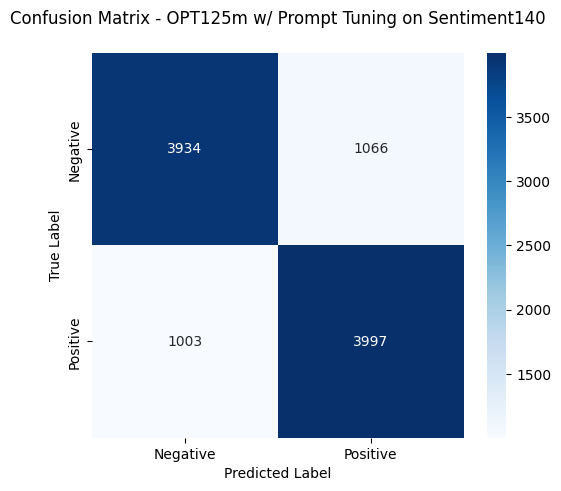

In [34]:
prompt_best_lr = results[0]["learning_rate"]
prompt_best_bs = results[0]["batch_size"]

# Construct filename
best_report_file = f"sent_opt_prompt_inference_metrics_summary_lr{prompt_best_lr}_bs{prompt_best_bs}.csv"

# Load the saved best report
best_report_df = pd.read_csv(best_report_file)
print("\nClassification Report for Best Configuration:")
print(best_report_df)


best_preds_df = pd.read_csv(f"sent_opt_prompt_inference_predictions_lr{prompt_best_lr}_bs{prompt_best_bs}.csv")
print("\nInference Predictions for Best Configuration:")
print(best_preds_df)

y_true = best_preds_df["y_true"]
y_pred = best_preds_df["y_pred"]


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - OPT125m w/ Prompt Tuning on Sentiment140\n")
plt.show()

##Begin Visualization of Sentiment140 Results

Load all dataframes from above training of 3 PEFT methods

In [38]:
""" Output from our OPT125M_Sentiment140_IMDb50k.ipynb file, we read in the .csv files here.
Note that these .csv file paths suggest they should be uploaded to session storage"""

# OPT125m PEFT-wise results across bf/lora/prompt tuning
opt_bf_results = pd.read_csv('/content/sent_opt_bitfit_results.csv')
opt_lora_results = pd.read_csv('/content/sent_opt_lora_results.csv')
opt_prompt_results = pd.read_csv('/content/sent_opt_prompt_results.csv')

# OPT125m per-epoch performance logs (for LC generation) across bf/lora/prompt tuning
opt_lora_epochs_lr5_bs8 = pd.read_csv('/content/sent_opt_lora_epoch_logs_lr5e-05_bs8.csv')
opt_lora_epochs_lr5_bs16 = pd.read_csv('/content/sent_opt_lora_epoch_logs_lr5e-05_bs16.csv')
opt_lora_epochs_lr1_bs8 = pd.read_csv('/content/sent_opt_lora_epoch_logs_lr0.0001_bs8.csv')
opt_lora_epochs_lr1_bs16 = pd.read_csv('/content/sent_opt_lora_epoch_logs_lr0.0001_bs16.csv')
opt_bf_epochs_lr5_bs8 = pd.read_csv('/content/sent_opt_bitfit_epoch_logs_lr5e-05_bs8.csv')
opt_bf_epochs_lr5_bs16 = pd.read_csv('/content/sent_opt_bitfit_epoch_logs_lr5e-05_bs16.csv')
opt_bf_epochs_lr1_bs8 = pd.read_csv('/content/sent_opt_bitfit_epoch_logs_lr0.0001_bs8.csv')
opt_bf_epochs_lr1_bs16 = pd.read_csv('/content/sent_opt_bitfit_epoch_logs_lr0.0001_bs16.csv')
opt_prompt_epochs_lr5_bs8 = pd.read_csv('/content/sent_opt_prompt_epoch_logs_lr5e-05_bs8.csv')
opt_prompt_epochs_lr5_bs16 = pd.read_csv('/content/sent_opt_prompt_epoch_logs_lr5e-05_bs16.csv')
opt_prompt_epochs_lr1_bs8 = pd.read_csv('/content/sent_opt_prompt_epoch_logs_lr0.0001_bs8.csv')
opt_prompt_epochs_lr1_bs16 = pd.read_csv('/content/sent_opt_prompt_epoch_logs_lr0.0001_bs16.csv')

# OPT125m inference performance metric summary across bf/lora/prompt tuning
opt_bf_inf_lr5_bs8 = pd.read_csv('/content/sent_opt_bitfit_inference_metrics_summary_lr5e-05_bs8.csv')
opt_bf_inf_lr5_bs16 = pd.read_csv('/content/sent_opt_bitfit_inference_metrics_summary_lr5e-05_bs16.csv')
opt_bf_inf_lr1_bs8 = pd.read_csv('/content/sent_opt_bitfit_inference_metrics_summary_lr0.0001_bs8.csv')
opt_bf_inf_lr1_bs16 = pd.read_csv('/content/sent_opt_bitfit_inference_metrics_summary_lr0.0001_bs16.csv')
opt_lora_inf_lr5_bs8 = pd.read_csv('/content/sent_opt_lora_inference_metrics_summary_lr5e-05_bs8.csv')
opt_lora_inf_lr5_bs16 = pd.read_csv('/content/sent_opt_lora_inference_metrics_summary_lr5e-05_bs16.csv')
opt_lora_inf_lr1_bs8 = pd.read_csv('/content/sent_opt_lora_inference_metrics_summary_lr0.0001_bs8.csv')
opt_lora_inf_lr1_bs16 = pd.read_csv('/content/sent_opt_lora_inference_metrics_summary_lr0.0001_bs16.csv')
opt_prompt_inf_lr5_bs8 = pd.read_csv('/content/sent_opt_prompt_inference_metrics_summary_lr5e-05_bs8.csv')
opt_prompt_inf_lr5_bs16 = pd.read_csv('/content/sent_opt_prompt_inference_metrics_summary_lr5e-05_bs16.csv')
opt_prompt_inf_lr1_bs8 = pd.read_csv('/content/sent_opt_prompt_inference_metrics_summary_lr0.0001_bs8.csv')
opt_prompt_inf_lr1_bs16 = pd.read_csv('/content/sent_opt_prompt_inference_metrics_summary_lr0.0001_bs16.csv')

# OPT125m inference predictions across bf/lora/prompt tuning
opt_bf_preds_lr5_bs8 = pd.read_csv('/content/sent_opt_bitfit_inference_predictions_lr5e-05_bs8.csv')
opt_bf_preds_lr5_bs16 = pd.read_csv('/content/sent_opt_bitfit_inference_predictions_lr5e-05_bs16.csv')
opt_bf_preds_lr1_bs8 = pd.read_csv('/content/sent_opt_bitfit_inference_predictions_lr0.0001_bs8.csv')
opt_bf_preds_lr1_bs16 = pd.read_csv('/content/sent_opt_bitfit_inference_predictions_lr0.0001_bs16.csv')
opt_lora_preds_lr5_bs8 = pd.read_csv('/content/sent_opt_lora_inference_predictions_lr5e-05_bs8.csv')
opt_lora_preds_lr5_bs16 = pd.read_csv('/content/sent_opt_lora_inference_predictions_lr5e-05_bs16.csv')
opt_lora_preds_lr1_bs8 = pd.read_csv('/content/sent_opt_lora_inference_predictions_lr0.0001_bs8.csv')
opt_lora_preds_lr1_bs16 = pd.read_csv('/content/sent_opt_lora_inference_predictions_lr0.0001_bs16.csv')
opt_prompt_preds_lr5_bs8 = pd.read_csv('/content/sent_opt_prompt_inference_predictions_lr5e-05_bs8.csv')
opt_prompt_preds_lr5_bs16 = pd.read_csv('/content/sent_opt_prompt_inference_predictions_lr5e-05_bs16.csv')
opt_prompt_preds_lr1_bs8 = pd.read_csv('/content/sent_opt_prompt_inference_predictions_lr0.0001_bs8.csv')
opt_prompt_preds_lr1_bs16 = pd.read_csv('/content/sent_opt_prompt_inference_predictions_lr0.0001_bs16.csv')

# OPT125m PEFT method intra-comparison based on hyperparameter settings, per bf/lora/prompt tuning
opt_bf_final_comparison = pd.read_csv('/content/sent_opt_bf_final_comparison_bitfit.csv')
opt_lora_final_comparison = pd.read_csv('/content/sent_opt_lora_final_comparison_lora.csv')
opt_prompt_final_comparison = pd.read_csv('/content/sent_opt_prompt_final_comparison_prompt_tuning.csv')


BitFit Learning Curves

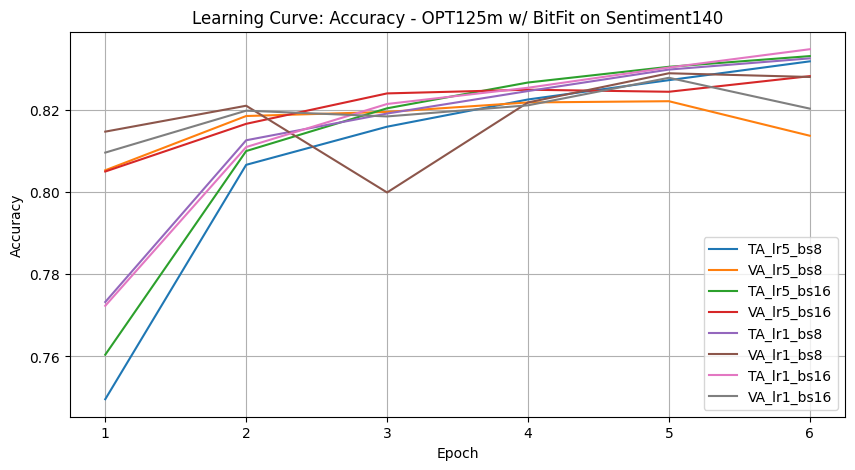

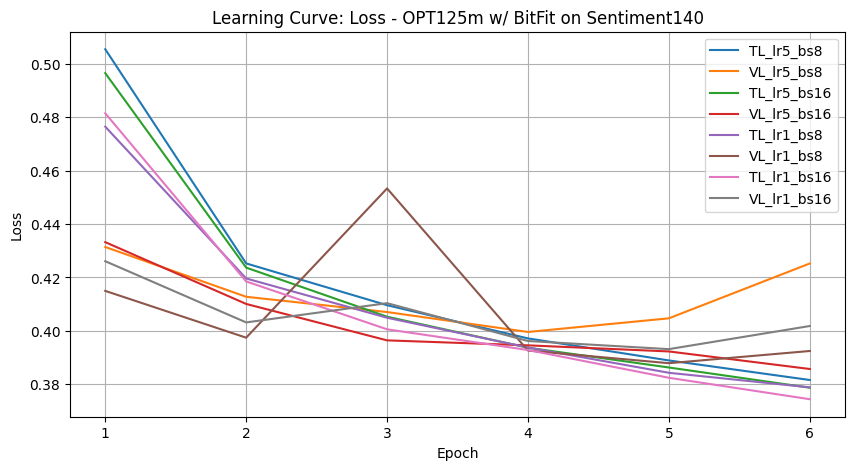

In [39]:
# All BitFit Train/Val Acc Learning Curve
plt.figure(figsize=(10,5))
sns.lineplot(data=opt_bf_epochs_lr5_bs8, x="epoch", y="train_accuracy", label="TA_lr5_bs8")
sns.lineplot(data=opt_bf_epochs_lr5_bs8, x="epoch", y="val_accuracy", label="VA_lr5_bs8")
sns.lineplot(data=opt_bf_epochs_lr5_bs16, x="epoch", y="train_accuracy", label="TA_lr5_bs16")
sns.lineplot(data=opt_bf_epochs_lr5_bs16, x="epoch", y="val_accuracy", label="VA_lr5_bs16")
sns.lineplot(data=opt_bf_epochs_lr1_bs8, x="epoch", y="train_accuracy", label="TA_lr1_bs8")
sns.lineplot(data=opt_bf_epochs_lr1_bs8, x="epoch", y="val_accuracy", label="VA_lr1_bs8")
sns.lineplot(data=opt_bf_epochs_lr1_bs16, x="epoch", y="train_accuracy", label="TA_lr1_bs16")
sns.lineplot(data=opt_bf_epochs_lr1_bs16, x="epoch", y="val_accuracy", label="VA_lr1_bs16")
plt.title("Learning Curve: Accuracy - OPT125m w/ BitFit on Sentiment140")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# All BitFit Training and Validation Loss
plt.figure(figsize=(10,5))
sns.lineplot(data=opt_bf_epochs_lr5_bs8, x="epoch", y="train_loss", label="TL_lr5_bs8")
sns.lineplot(data=opt_bf_epochs_lr5_bs8, x="epoch", y="val_loss", label="VL_lr5_bs8")
sns.lineplot(data=opt_bf_epochs_lr5_bs16, x="epoch", y="train_loss", label="TL_lr5_bs16")
sns.lineplot(data=opt_bf_epochs_lr5_bs16, x="epoch", y="val_loss", label="VL_lr5_bs16")
sns.lineplot(data=opt_bf_epochs_lr1_bs8, x="epoch", y="train_loss", label="TL_lr1_bs8")
sns.lineplot(data=opt_bf_epochs_lr1_bs8, x="epoch", y="val_loss", label="VL_lr1_bs8")
sns.lineplot(data=opt_bf_epochs_lr1_bs16, x="epoch", y="train_loss", label="TL_lr1_bs16")
sns.lineplot(data=opt_bf_epochs_lr1_bs16, x="epoch", y="val_loss", label="VL_lr1_bs16")
plt.title("Learning Curve: Loss - OPT125m w/ BitFit on Sentiment140")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

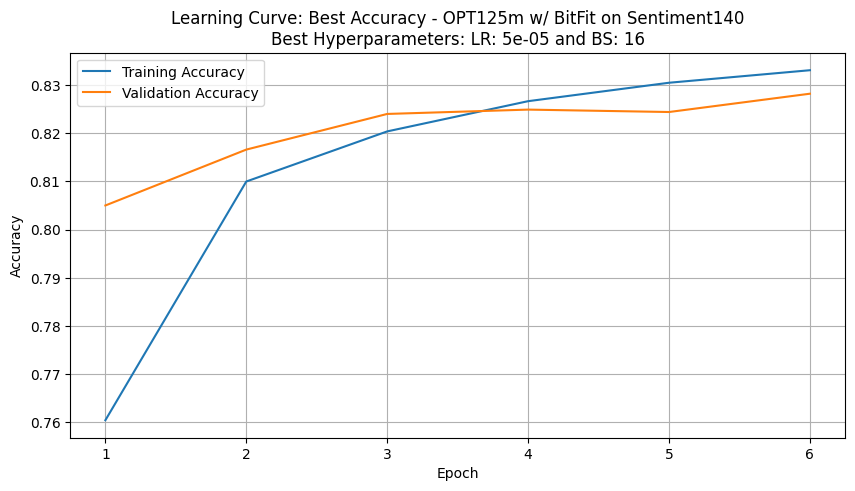

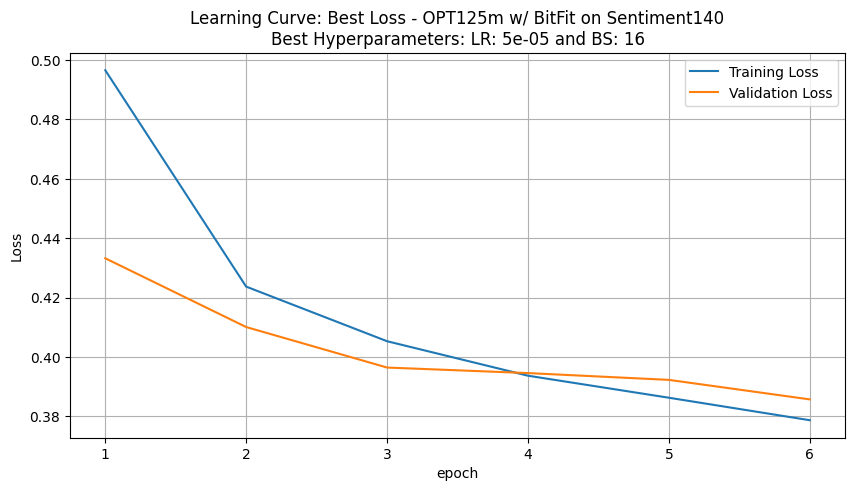

In [40]:
# Best BitFit Train/Val Acc Learning Curve

opt_bf_epochs_map = {
    (5, 8): opt_bf_epochs_lr5_bs8,
    (5, 16): opt_bf_epochs_lr5_bs16,
    (1, 8): opt_bf_epochs_lr1_bs8,
    (1, 16): opt_bf_epochs_lr1_bs16
}

bf_lr_mapping = {
    5e-5: 5,
    1e-4: 1
}

bf_best_lr_tag = bf_lr_mapping[bf_best_lr]
bf_best_bs_tag = bf_best_bs

bf_epochs = opt_bf_epochs_map[(bf_best_lr_tag, bf_best_bs_tag)]

# Best BitFit Training and Validation Accuracy
plt.figure(figsize=(10,5))
sns.lineplot(data=bf_epochs, x="epoch", y="train_accuracy", label="Training Accuracy")
sns.lineplot(data=bf_epochs, x="epoch", y="val_accuracy", label="Validation Accuracy")
plt.title(f"Learning Curve: Best Accuracy - OPT125m w/ BitFit on Sentiment140\nBest Hyperparameters: LR: {bf_best_lr} and BS: {bf_best_bs}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Best BitFit Training and Validation Loss
plt.figure(figsize=(10,5))
sns.lineplot(data=bf_epochs, x="epoch", y="train_loss", label="Training Loss")
sns.lineplot(data=bf_epochs, x="epoch", y="val_loss", label="Validation Loss")
plt.title(f"Learning Curve: Best Loss - OPT125m w/ BitFit on Sentiment140\nBest Hyperparameters: LR: {bf_best_lr} and BS: {bf_best_bs}")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

LoRA Learning Curves

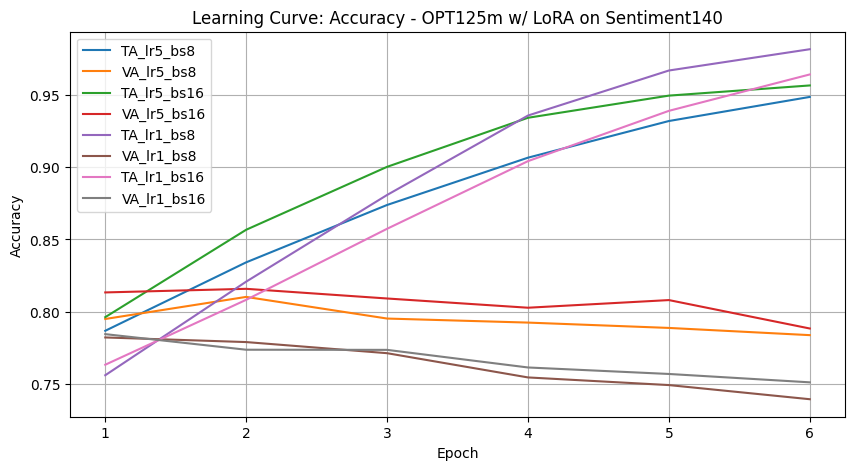

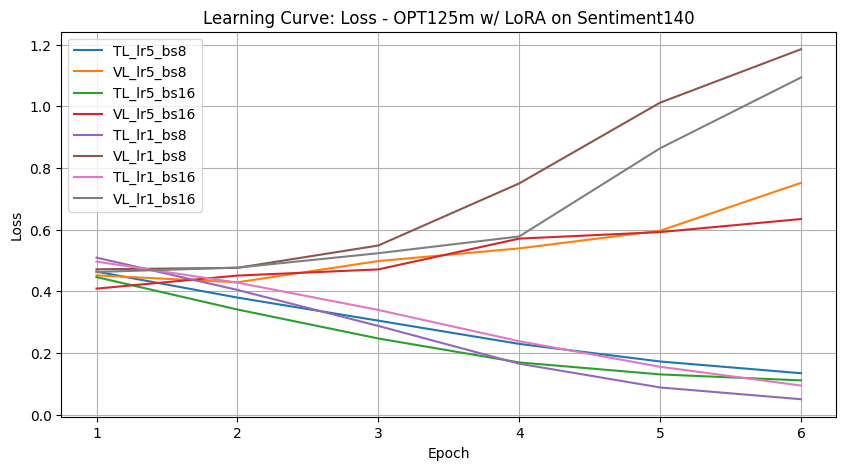

In [41]:
# All LoRA Train/Val Acc Learning Curve
plt.figure(figsize=(10,5))
sns.lineplot(data=opt_lora_epochs_lr5_bs8, x="epoch", y="train_accuracy", label="TA_lr5_bs8")
sns.lineplot(data=opt_lora_epochs_lr5_bs8, x="epoch", y="val_accuracy", label="VA_lr5_bs8")
sns.lineplot(data=opt_lora_epochs_lr5_bs16, x="epoch", y="train_accuracy", label="TA_lr5_bs16")
sns.lineplot(data=opt_lora_epochs_lr5_bs16, x="epoch", y="val_accuracy", label="VA_lr5_bs16")
sns.lineplot(data=opt_lora_epochs_lr1_bs8, x="epoch", y="train_accuracy", label="TA_lr1_bs8")
sns.lineplot(data=opt_lora_epochs_lr1_bs8, x="epoch", y="val_accuracy", label="VA_lr1_bs8")
sns.lineplot(data=opt_lora_epochs_lr1_bs16, x="epoch", y="train_accuracy", label="TA_lr1_bs16")
sns.lineplot(data=opt_lora_epochs_lr1_bs16, x="epoch", y="val_accuracy", label="VA_lr1_bs16")
plt.title("Learning Curve: Accuracy - OPT125m w/ LoRA on Sentiment140")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# All LoRA Training and Validation Loss
plt.figure(figsize=(10,5))
sns.lineplot(data=opt_lora_epochs_lr5_bs8, x="epoch", y="train_loss", label="TL_lr5_bs8")
sns.lineplot(data=opt_lora_epochs_lr5_bs8, x="epoch", y="val_loss", label="VL_lr5_bs8")
sns.lineplot(data=opt_lora_epochs_lr5_bs16, x="epoch", y="train_loss", label="TL_lr5_bs16")
sns.lineplot(data=opt_lora_epochs_lr5_bs16, x="epoch", y="val_loss", label="VL_lr5_bs16")
sns.lineplot(data=opt_lora_epochs_lr1_bs8, x="epoch", y="train_loss", label="TL_lr1_bs8")
sns.lineplot(data=opt_lora_epochs_lr1_bs8, x="epoch", y="val_loss", label="VL_lr1_bs8")
sns.lineplot(data=opt_lora_epochs_lr1_bs16, x="epoch", y="train_loss", label="TL_lr1_bs16")
sns.lineplot(data=opt_lora_epochs_lr1_bs16, x="epoch", y="val_loss", label="VL_lr1_bs16")
plt.title("Learning Curve: Loss - OPT125m w/ LoRA on Sentiment140")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

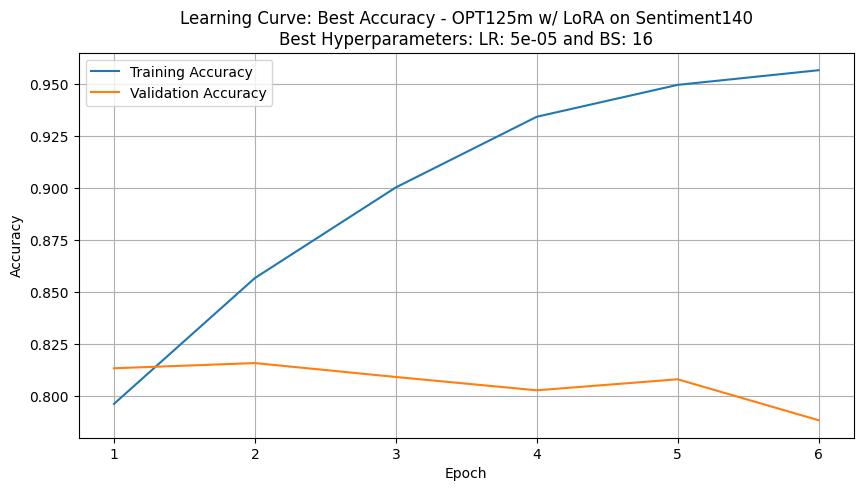

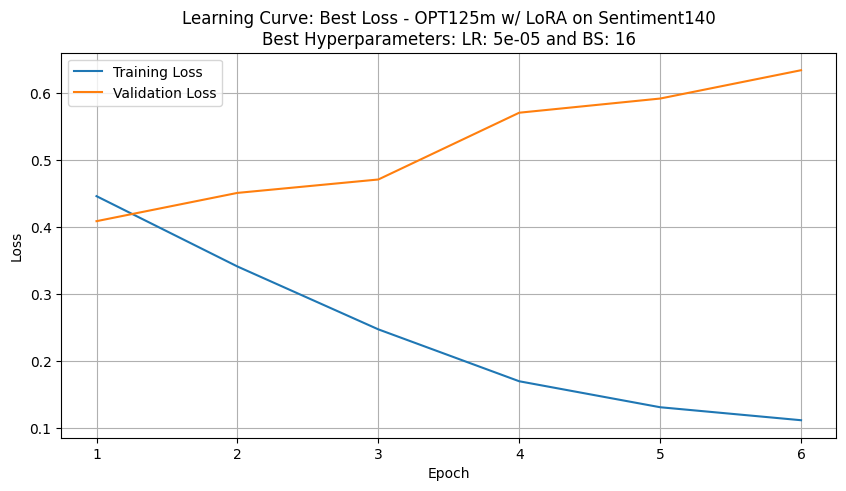

In [42]:
# Best LoRA Train/Val Acc Learning Curve

opt_lora_epochs_map = {
    (5, 8): opt_lora_epochs_lr5_bs8,
    (5, 16): opt_lora_epochs_lr5_bs16,
    (1, 8): opt_lora_epochs_lr1_bs8,
    (1, 16): opt_lora_epochs_lr1_bs16
}

lora_lr_mapping = {
    5e-5: 5,
    1e-4: 1
}

lora_best_lr_tag = lora_lr_mapping[lora_best_lr]
lora_best_bs_tag = lora_best_bs

lora_epochs = opt_lora_epochs_map[(lora_best_lr_tag, lora_best_bs_tag)]

# Best LoRA Training and Validation Accuracy
plt.figure(figsize=(10,5))
sns.lineplot(data=lora_epochs, x="epoch", y="train_accuracy", label="Training Accuracy")
sns.lineplot(data=lora_epochs, x="epoch", y="val_accuracy", label="Validation Accuracy")
plt.title(f"Learning Curve: Best Accuracy - OPT125m w/ LoRA on Sentiment140\nBest Hyperparameters: LR: {lora_best_lr} and BS: {lora_best_bs}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Best LoRA Training and Validation Loss
plt.figure(figsize=(10,5))
sns.lineplot(data=lora_epochs, x="epoch", y="train_loss", label="Training Loss")
sns.lineplot(data=lora_epochs, x="epoch", y="val_loss", label="Validation Loss")
plt.title(f"Learning Curve: Best Loss - OPT125m w/ LoRA on Sentiment140\nBest Hyperparameters: LR: {lora_best_lr} and BS: {lora_best_bs}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

Prompt Tuning Learning Curves

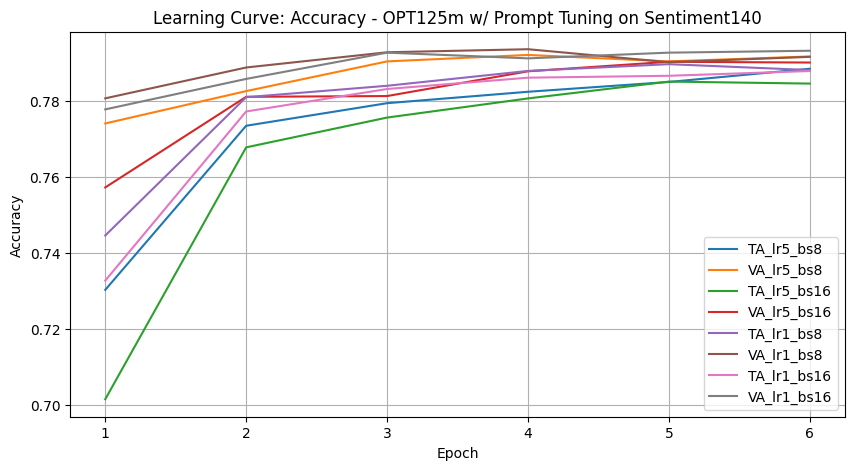

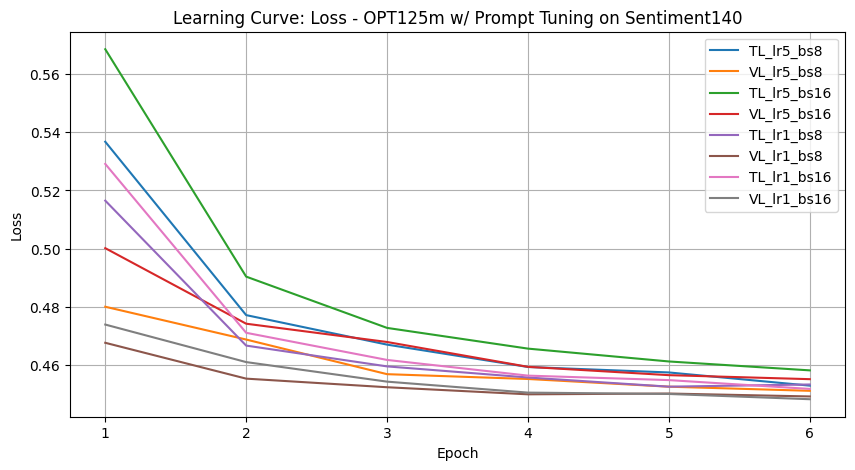

In [43]:
# All Prompt Tuning Train/Val Acc Learning Curve
plt.figure(figsize=(10,5))
sns.lineplot(data=opt_prompt_epochs_lr5_bs8, x="epoch", y="train_accuracy", label="TA_lr5_bs8")
sns.lineplot(data=opt_prompt_epochs_lr5_bs8, x="epoch", y="val_accuracy", label="VA_lr5_bs8")
sns.lineplot(data=opt_prompt_epochs_lr5_bs16, x="epoch", y="train_accuracy", label="TA_lr5_bs16")
sns.lineplot(data=opt_prompt_epochs_lr5_bs16, x="epoch", y="val_accuracy", label="VA_lr5_bs16")
sns.lineplot(data=opt_prompt_epochs_lr1_bs8, x="epoch", y="train_accuracy", label="TA_lr1_bs8")
sns.lineplot(data=opt_prompt_epochs_lr1_bs8, x="epoch", y="val_accuracy", label="VA_lr1_bs8")
sns.lineplot(data=opt_prompt_epochs_lr1_bs16, x="epoch", y="train_accuracy", label="TA_lr1_bs16")
sns.lineplot(data=opt_prompt_epochs_lr1_bs16, x="epoch", y="val_accuracy", label="VA_lr1_bs16")
plt.title("Learning Curve: Accuracy - OPT125m w/ Prompt Tuning on Sentiment140")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# All Prompt Tuning Training and Validation Loss
plt.figure(figsize=(10,5))
sns.lineplot(data=opt_prompt_epochs_lr5_bs8, x="epoch", y="train_loss", label="TL_lr5_bs8")
sns.lineplot(data=opt_prompt_epochs_lr5_bs8, x="epoch", y="val_loss", label="VL_lr5_bs8")
sns.lineplot(data=opt_prompt_epochs_lr5_bs16, x="epoch", y="train_loss", label="TL_lr5_bs16")
sns.lineplot(data=opt_prompt_epochs_lr5_bs16, x="epoch", y="val_loss", label="VL_lr5_bs16")
sns.lineplot(data=opt_prompt_epochs_lr1_bs8, x="epoch", y="train_loss", label="TL_lr1_bs8")
sns.lineplot(data=opt_prompt_epochs_lr1_bs8, x="epoch", y="val_loss", label="VL_lr1_bs8")
sns.lineplot(data=opt_prompt_epochs_lr1_bs16, x="epoch", y="train_loss", label="TL_lr1_bs16")
sns.lineplot(data=opt_prompt_epochs_lr1_bs16, x="epoch", y="val_loss", label="VL_lr1_bs16")
plt.title("Learning Curve: Loss - OPT125m w/ Prompt Tuning on Sentiment140")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

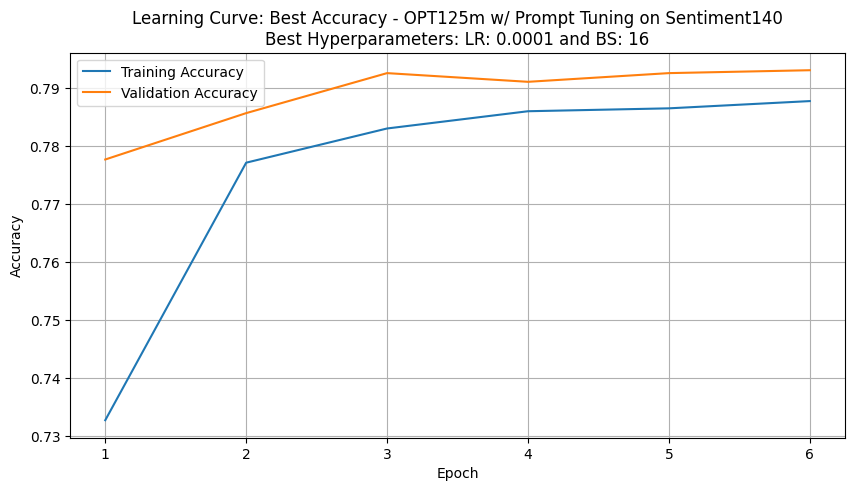

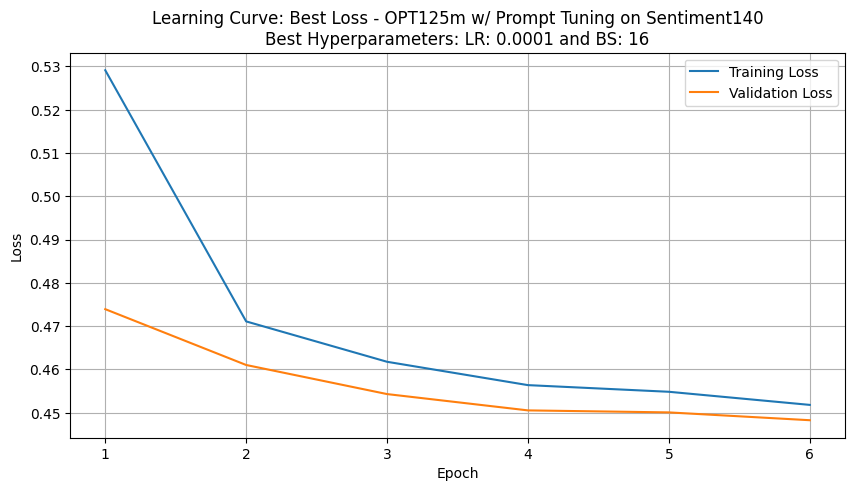

In [52]:
# Best Prompt Tuning Train/Val Acc Learning Curve

opt_prompt_epochs_map = {
    (5, 8): opt_prompt_epochs_lr5_bs8,
    (5, 16): opt_prompt_epochs_lr5_bs16,
    (1, 8): opt_prompt_epochs_lr1_bs8,
    (1, 16): opt_prompt_epochs_lr1_bs16
}

prompt_lr_mapping = {
    5e-5: "5e-5",
    1e-4: "1e-4"
}

prompt_best_lr_tag_for_map = {5e-5: 5, 1e-4: 1}[prompt_best_lr]

prompt_best_bs_tag = prompt_best_bs

prompt_epochs = opt_prompt_epochs_map[(prompt_best_lr_tag_for_map, prompt_best_bs_tag)]

# Best Prompt Tuning Training and Validation Accuracy
plt.figure(figsize=(10,5))
sns.lineplot(data=prompt_epochs, x="epoch", y="train_accuracy", label="Training Accuracy")
sns.lineplot(data=prompt_epochs, x="epoch", y="val_accuracy", label="Validation Accuracy")
plt.title(f"Learning Curve: Best Accuracy - OPT125m w/ Prompt Tuning on Sentiment140\nBest Hyperparameters: LR: {prompt_best_lr} and BS: {prompt_best_bs}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Best Prompt Tuning Training and Validation Loss
plt.figure(figsize=(10,5))
sns.lineplot(data=prompt_epochs, x="epoch", y="train_loss", label="Training Loss")
sns.lineplot(data=prompt_epochs, x="epoch", y="val_loss", label="Validation Loss")
plt.title(f"Learning Curve: Best Loss - OPT125m w/ Prompt Tuning on Sentiment140\nBest Hyperparameters: LR: {prompt_best_lr} and BS: {prompt_best_bs}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

PEFT Method Comparison:

In [53]:
# Final results per BitFit/LoRA/Prompt Tuning Implementation

opt_bf_results = pd.read_csv('/content/sent_opt_bitfit_results.csv')
opt_lora_results = pd.read_csv('/content/sent_opt_lora_results.csv')
opt_prompt_results = pd.read_csv('/content/sent_opt_prompt_results.csv')

# Table of comparisons
comparison = pd.DataFrame({
    "Method": ["BitFit", "LoRA", "Prompt Tuning"],
    "Best Validation F1": [
        opt_bf_results["f1"].max(),
        opt_lora_results["f1"].max(),
        opt_prompt_results["f1"].max()
    ],
    "Best Validation Accuracy": [
        opt_bf_results["accuracy"].max(),
        opt_lora_results["accuracy"].max(),
        opt_prompt_results["accuracy"].max()
    ],
    "Runtime (sec)": [
        opt_bf_results["training_time"].sum(),
        opt_lora_results["training_time"].sum(),
        opt_prompt_results["training_time"].sum()
    ],
    "Inference Time (sec)": [
        opt_bf_results["inference_time"].sum(),
        opt_lora_results["inference_time"].sum(),
        opt_prompt_results["inference_time"].sum()
    ],
    "Max GPU Memory (GB)": [
        opt_bf_results["max_memory"].max(),
        opt_lora_results["max_memory"].max(),
        opt_prompt_results["max_memory"].max()
    ]
})

print("\nFinal Validation Performance PEFT Comparison - OPT125m on Sentiment140:")
display(comparison)



Final Validation Performance PEFT Comparison - OPT125m on Sentiment140:


,Method,Best Validation F1,Best Validation Accuracy,Runtime (sec),Inference Time (sec),Max GPU Memory (GB)
0,BitFit,0.828179,0.8282,3571.217733,48.324579,4.302316
1,LoRA,0.787669,0.7883,4772.803699,44.897412,4.302316
2,Prompt Tuning,0.793092,0.7931,1796.638002,1796.377568,4.302316


In [55]:
# Load overall results where inference_time is stored
opt_prompt_results = pd.read_csv('/content/sent_opt_prompt_results.csv')
opt_bf_results = pd.read_csv('/content/sent_opt_bitfit_results.csv')
opt_lora_results = pd.read_csv('/content/sent_opt_lora_results.csv')

# Manually map best learning rates to filename tags (from before)
lr_tag_mapping = {
    5e-5: "5e-05",
    1e-4: "0.0001"
}
bf_best_lr_tag = lr_tag_mapping[bf_best_lr]
lora_best_lr_tag = lr_tag_mapping[lora_best_lr]
prompt_best_lr_tag = lr_tag_mapping[prompt_best_lr]

# Load best inference metric summaries
bf_inf = pd.read_csv(f'/content/sent_opt_bitfit_inference_metrics_summary_lr{bf_best_lr_tag}_bs{bf_best_bs}.csv', index_col=0)
lora_inf = pd.read_csv(f'/content/sent_opt_lora_inference_metrics_summary_lr{lora_best_lr_tag}_bs{lora_best_bs}.csv', index_col=0)
prompt_inf = pd.read_csv(f'/content/sent_opt_prompt_inference_metrics_summary_lr{prompt_best_lr_tag}_bs{prompt_best_bs}.csv', index_col=0)

# Extract inference times
bf_inference_time = opt_bf_results[
    (opt_bf_results["learning_rate"] == bf_best_lr) &
    (opt_bf_results["batch_size"] == bf_best_bs)
]["inference_time"].values[0]

lora_inference_time = opt_lora_results[
    (opt_lora_results["learning_rate"] == lora_best_lr) &
    (opt_lora_results["batch_size"] == lora_best_bs)
]["inference_time"].values[0]

prompt_inference_time = opt_prompt_results[
    (opt_prompt_results["learning_rate"] == prompt_best_lr) &
    (opt_prompt_results["batch_size"] == prompt_best_bs)
]["inference_time"].values[0]

# Table of best per-implementation metrics (based on best lr and bs per PEFT method)
final_test_results = pd.DataFrame({
    "Method": ["BitFit", "LoRA", "Prompt Tuning"],
    "Test Accuracy": [
        bf_inf.loc["accuracy", "precision"],
        lora_inf.loc["accuracy", "precision"],
        prompt_inf.loc["accuracy", "precision"]
    ],
    "F1 Macro": [
        bf_inf.loc["macro avg", "f1-score"],
        lora_inf.loc["macro avg", "f1-score"],
        prompt_inf.loc["macro avg", "f1-score"]
    ],
    "F1 Weighted": [
        bf_inf.loc["weighted avg", "f1-score"],
        lora_inf.loc["weighted avg", "f1-score"],
        prompt_inf.loc["weighted avg", "f1-score"]
    ],
    "Inference Time (sec)": [
        bf_inference_time,
        lora_inference_time,
        prompt_inference_time
    ]
})

print("\nFinal Test Set Inference Performance PEFT Comparison - OPT125m on Sentiment140:")
display(final_test_results)


Final Test Set Inference Performance PEFT Comparison - OPT125m on Sentiment140:


,Method,Test Accuracy,F1 Macro,F1 Weighted,Inference Time (sec)
0,BitFit,0.8282,0.828179,0.828179,8.573552
1,LoRA,0.7883,0.787669,0.787669,7.885467
2,Prompt Tuning,0.7931,0.793092,0.793092,309.962967


In [ ]:
# Zip the entire /content folder
!zip -r /content/OPT_Sentiment_solo.zip /content

# Download the zipped file
from google.colab import files
files.download('/content/OPT_Sentiment_solo.zip')

##Make sure you don't delete this